# Data Pipeline for Vesuvius Ink Detection Baseline

## Overview
This notebook implements the data loading and augmentation pipeline for 2.5D segmentation.
- **Key Components**:
  - Fragment loader: Compute per-fragment percentiles (0.5-99.5), erode mask by 8px, collect tile coordinates (512x512) inside eroded mask.
  - Sampler: 60% positive tiles (ink_ratio >=1%), 25% hard negatives (near dilated ink, radius=16px), 15% random negatives.
  - Dataset: For each sample, stack 16 z-slices centered at z=30 (bounds-checked), normalize using fragment percentiles, apply augmentations identically to all channels.
  - DataLoader: PyTorch with num_workers=4, batch_size=8, AMP-ready.
- **Z-Window**: 16 slices, center=30 (e.g., z=22-37 for fragment 1 with 65 slices).
- **Augmentations**: Albumentations - HFlip/VFlip/Rot90 (p=0.75), ShiftScaleRotate (shift=0.05, scale=0.1, rotate=10, p=0.5), RandomBrightnessContrast (0.2, p=0.5), GaussianNoise (var=10, p=0.2).
- **Efficiency**: Use tifffile.memmap for on-the-fly slice reading; precompute coords and ink_ratios.

## Next Steps
1. Implement fragment loader and compute stats for train fragments 1 and 2.
2. Build TileSampler class to generate indices with balanced ratios.
3. Implement VesuviusDataset class with __getitem__ for 2.5D patches.
4. Create test DataLoader and visualize a batch (input stack, target mask).
5. Verify: ink_ratio distribution, normalization (0-1), augs applied consistently.
6. Request expert review on pipeline before training in '02_baseline_training.ipynb'.

## Targets
- Ensure no leakage: Percentiles fit on train fold only.
- Mask handling: Targets multiplied by original mask; loss only on eroded area.
- For inference: Similar but no augs, full sliding window with Gaussian blend.

In [1]:
# Imports
import os
import numpy as np
import cv2
from glob import glob
import tifffile
from scipy.ndimage import binary_dilation
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from typing import List, Tuple, Dict, Optional
import matplotlib.pyplot as plt
from collections import defaultdict

# Verify GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

/app/.pip-target/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [6]:
# FragmentLoader class
class FragmentLoader:
    def __init__(self, fragment_id: str, tile_size: int = 512, stride: int = 256, erosion: int = 8, pos_threshold: float = 0.01, hard_neg_radius: int = 16, z_center: int = 30, z_window: int = 16):
        self.fragment_id = fragment_id
        self.volume_path = f'train/{fragment_id}/surface_volume/'
        self.mask_path = f'train/{fragment_id}/mask.png'
        self.inklabels_path = f'train/{fragment_id}/inklabels.png'
        self.tile_size = tile_size
        self.stride = stride
        self.erosion = erosion
        self.pos_threshold = pos_threshold
        self.hard_neg_radius = hard_neg_radius
        self.z_center = z_center
        self.z_window = z_window
        
        self.volume_files = sorted(glob(os.path.join(self.volume_path, '*.tif')))
        self.load_fragment()
        
    def load_fragment(self):
        # Load mask and inklabels
        self.mask = cv2.imread(self.mask_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
        self.inklabels = cv2.imread(self.inklabels_path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
        
        # Compute percentiles within mask by sampling every 5th slice
        mask_bool = self.mask > 0
        vals = []
        sample_indices = list(range(0, len(self.volume_files), 5))
        for idx in sample_indices:
            slice_data = tifffile.imread(self.volume_files[idx])
            vals.append(slice_data[mask_bool])
        vals = np.concatenate(vals)
        self.p05 = np.percentile(vals, 0.5)
        self.p995 = np.percentile(vals, 99.5)
        print(f'Fragment {self.fragment_id} percentiles (in-mask): p05={self.p05}, p995={self.p995}')
        
        # Erode mask
        kernel = np.ones((self.erosion, self.erosion), np.uint8)
        eroded_uint8 = cv2.erode((self.mask * 255).astype(np.uint8), kernel)
        self.eroded_mask = eroded_uint8.astype(np.float32) / 255.0
        
        # Dilate ink for hard negatives
        self.dilated_ink = binary_dilation(self.inklabels > 0, iterations=self.hard_neg_radius)
        
        # Generate candidate tile coordinates
        self.coords = []
        self.ink_ratios = []
        self.types = []
        h, w = self.mask.shape
        for i in range(0, h - self.tile_size + 1, self.stride):
            for j in range(0, w - self.tile_size + 1, self.stride):
                tile_eroded = self.eroded_mask[i:i+self.tile_size, j:j+self.tile_size]
                coverage = np.sum(tile_eroded > 0) / (self.tile_size ** 2)
                if coverage > 0.95:
                    tile_ink = self.inklabels[i:i+self.tile_size, j:j+self.tile_size]
                    masked_ink_pixels = np.sum(tile_ink * tile_eroded > 0)
                    masked_pixels = np.sum(tile_eroded > 0)
                    ink_ratio = masked_ink_pixels / masked_pixels if masked_pixels > 0 else 0
                    self.coords.append((i, j))
                    self.ink_ratios.append(ink_ratio)
                    # Classify type
                    if ink_ratio >= self.pos_threshold:
                        tile_type = 'pos'
                    else:
                        tile_dilated = self.dilated_ink[i:i+self.tile_size, j:j+self.tile_size]
                        if np.sum(tile_dilated) > 0:
                            tile_type = 'hard_neg'
                        else:
                            tile_type = 'neg'
                    self.types.append(tile_type)
        
        # Debug ink ratios
        if self.ink_ratios:
            print(f'Ink ratios stats: min={min(self.ink_ratios):.4f}, max={max(self.ink_ratios):.4f}, mean={np.mean(self.ink_ratios):.4f}')
            print(f'Num tiles with ratio >= {self.pos_threshold}: {sum(r >= self.pos_threshold for r in self.ink_ratios)}')
        
        # Stats
        self.num_pos = sum(1 for t in self.types if t == 'pos')
        self.num_hard_neg = sum(1 for t in self.types if t == 'hard_neg')
        self.num_neg = sum(1 for t in self.types if t == 'neg')
        total = len(self.coords)
        print(f'Fragment {self.fragment_id}: Total tiles: {total}, Pos: {self.num_pos} ({self.num_pos/total*100:.1f}%), HardNeg: {self.num_hard_neg} ({self.num_hard_neg/total*100:.1f}%), Neg: {self.num_neg} ({self.num_neg/total*100:.1f}%)')
        
    def get_data_dict(self):
        return {
            'coords': self.coords,
            'ink_ratios': self.ink_ratios,
            'types': self.types,
            'p05': self.p05,
            'p995': self.p995,
            'eroded_mask': self.eroded_mask,
            'mask': self.mask,
            'inklabels': self.inklabels,
            'volume_files': self.volume_files,
            'z_center': self.z_center,
            'z_window': self.z_window
        }

# Test on fragment 1
loader1 = FragmentLoader('1')
data1 = loader1.get_data_dict()
print(f'Z window: {data1["z_window"]} slices centered at {data1["z_center"]}')

Fragment 1 percentiles (in-mask): p05=3988.0, p995=49174.0


Ink ratios stats: min=0.0000, max=0.6715, mean=0.2042
Num tiles with ratio >= 0.01: 296
Fragment 1: Total tiles: 348, Pos: 296 (85.1%), HardNeg: 9 (2.6%), Neg: 43 (12.4%)
Z window: 16 slices centered at 30


Batch image shape: torch.Size([2, 16, 512, 512])
Batch mask shape: torch.Size([2, 1, 512, 512])
Batch valid shape: torch.Size([2, 1, 512, 512])


First 4 sample types: ['hard_neg', 'pos', 'pos', 'hard_neg']
Ratio pos in first 4: 0.5


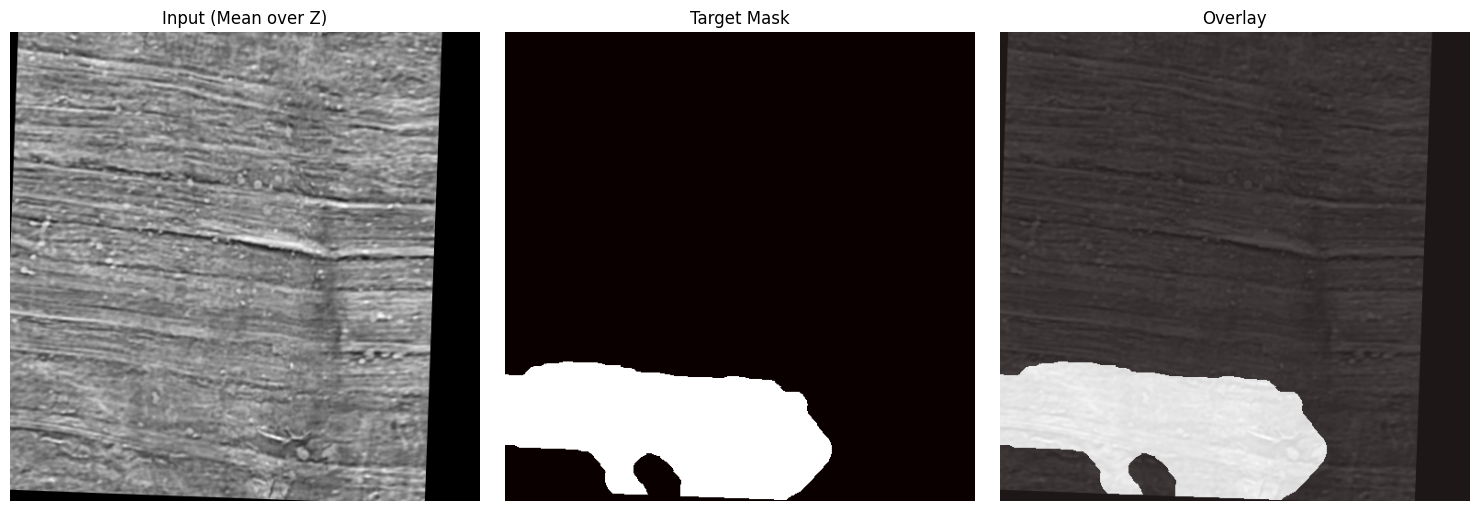

In [7]:
# TileSampler and VesuviusDataset
import torch.utils.data

class TileSampler(torch.utils.data.Sampler):
    def __init__(self, types: List[str], target_ratios: Dict[str, float]):
        self.indices = list(range(len(types)))
        type_counts = {t: sum(1 for typ in types if typ == t) for t in target_ratios.keys() if sum(1 for typ in types if typ == t) > 0}
        self.sampler = torch.utils.data.WeightedRandomSampler([
            target_ratios.get(typ, 0.0) / max(type_counts.get(typ, 1), 1) for typ in types
        ], len(types), replacement=True)

    def __iter__(self):
        return iter(self.sampler)

    def __len__(self):
        return len(self.sampler)

class VesuviusDataset(Dataset):
    def __init__(self, data_dict: Dict, transform=None):
        self.data = data_dict
        self.transform = transform
        self.tile_size = 512
        self._mm = {}  # Memmap cache

    def __len__(self):
        return len(self.data['coords'])

    def _roi(self, z_idx, i, j):
        fn = self.data['volume_files'][z_idx]
        if fn not in self._mm:
            self._mm[fn] = tifffile.memmap(fn)
        return self._mm[fn][i:i+self.tile_size, j:j+self.tile_size]

    def __getitem__(self, idx):
        i, j = self.data['coords'][idx]
        n = len(self.data['volume_files'])
        w = self.data['z_window']
        c = self.data['z_center']
        z_start = max(0, min(c - w // 2, n - w))
        z_end = z_start + w
        p05, p995 = self.data['p05'], self.data['p995']
        den = (p995 - p05 + 1e-8)

        stack = []
        for z in range(z_start, z_end):
            x = self._roi(z, i, j).astype(np.float32)
            x = np.clip((x - p05) / den, 0, 1)
            stack.append(x)
        stack = np.stack(stack, axis=-1)  # (512, 512, C)

        eroded_tile = self.data['eroded_mask'][i:i+self.tile_size, j:j+self.tile_size]
        ink_tile = self.data['inklabels'][i:i+self.tile_size, j:j+self.tile_size]
        target = ink_tile * eroded_tile
        valid = eroded_tile

        if self.transform:
            augmented = self.transform(image=stack, mask=target)
            image = augmented['image']
            mask = augmented['mask'].unsqueeze(0)
        else:
            image = torch.from_numpy(stack.transpose(2, 0, 1)).float()
            mask = torch.from_numpy(target).unsqueeze(0).float()
        valid = torch.from_numpy(valid).unsqueeze(0).float()
        return {'image': image, 'mask': mask, 'valid': valid}

# Define transform (fixed augs)
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.GaussianBlur(blur_limit=(3, 5), p=0.15),
    ToTensorV2()
])

# Test Dataset and DataLoader (with speed tweaks)
target_ratios = {'pos': 0.6, 'hard_neg': 0.25, 'neg': 0.15}
dataset = VesuviusDataset(data1, transform=train_transform)
sampler = TileSampler(data1['types'], target_ratios)
dataloader = DataLoader(dataset, batch_size=2, sampler=sampler, num_workers=2, pin_memory=True, persistent_workers=True, prefetch_factor=2)

# Get one batch
batch = next(iter(dataloader))
print(f'Batch image shape: {batch["image"].shape}')  # [2, 16, 512, 512]
print(f'Batch mask shape: {batch["mask"].shape}')  # [2, 1, 512, 512]
print(f'Batch valid shape: {batch["valid"].shape}')

# Visualize first sample in batch
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sample_img = batch['image'][0].mean(dim=0).numpy()  # Average over channels
sample_mask = batch['mask'][0][0].numpy()
sample_valid = batch['valid'][0][0].numpy()
axes[0].imshow(sample_img, cmap='gray')
axes[0].set_title('Input (Mean over Z)')
axes[1].imshow(sample_mask, cmap='hot')
axes[1].set_title('Target Mask')
axes[2].imshow(sample_img, cmap='gray', alpha=0.7)
axes[2].imshow(sample_mask > 0, cmap='hot', alpha=0.7)
axes[2].set_title('Overlay')
for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

# Check types in first few samples (manual check)
first_indices = list(sampler)[:4]
first_types = [data1['types'][idx] for idx in first_indices]
print(f'First 4 sample types: {first_types}')
print(f'Ratio pos in first 4: {sum(1 for t in first_types if t=="pos") / 4}')

# Note: For full balance check, run multiple batches and count
# Time check: This should be faster now with ROI reads